<table style="width :100%;">
    <td style="width : 7.5%;">
        <img style="float: left;
                width: 75px;"
         src="https://upload.wikimedia.org/wikipedia/fr/d/d9/Logo_T%C3%A9l%C3%A9com_ParisTech.svg" />
    </td>
    <td style="width : 15%;">
        TELECOM PARIS<br />2021/2022<br /><br /> IA702<br />Mme Anne Sabourin
    </td>
    <td>
        <h1><center>PROBABILISTIC MODELS & MACHINE LEARNING<br /><br />TP2 : La Segmentation d'image</center></h1>
    </td>
    <td style="width : 12.5%;">
        Alexandre ROULEAU <br />Date TP : 2021/10/06<br /><br /> Date CR : 2021/10/24<br /> Version : 0
    </td>
</table>    

<hr>
<h1>1. La segmentation bayésienne d'image</h1>
<hr>
<h2>1.1. Imports des packages/librairies/modules Python</h2>

In [1]:
import cv2 as cv
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt   
import numpy as np
import os
from os import listdir
from os.path import isfile, join
import pandas as pd
import seaborn as sns

from math import log2, sqrt
from scipy.stats import norm
from sklearn.cluster import KMeans

<h2>1.2. Imports de fonctions Python prédéfinies</h2>

In [2]:
import utils
help(utils)

Help on module utils:

NAME
    utils

FUNCTIONS
    MAP_MPM2(Y, cl1, cl2, p1, p2, m1, sig1, m2, sig2)
    
    bruit_gauss2(X, cl1, cl2, m1, sig1, m2, sig2)
    
    calc_probaprio2(X, cl1, cl2)
    
    get_line_index(dSize)
        Cette fonction permet d'obtenir l'ordre de parcours des pixels d'une image carrée selon un parcours ligne par ligne
        :param dSize: largeur ou longueur de l'image en pixel (peu importe, la fonction ne fonctionne qu'avec des images carrées)
        :return: une liste de taille 2*dSize*dSize qui correspond aux coordonnées de chaque pixel ordonnée selon le parcours ligne par ligne
    
    get_peano_index(dSize)
        Cette fonction permet d'obtenir l'ordre de parcours des pixels d'une image carrée (dont la dimension est une puissance de 2)
        selon la courbe de Hilbert-Peano
        :param dSize: largeur ou longueur de l'image en pixel (peu importe, la fonction de fonctionne qu'avec des images carrées)
        :return: une liste de taille 2*dSi

<hr>
<h1>2. PARTIE I : Modèle des couples indépendants</h1>
<hr>
<h2>2.1. Question 3 : Ecriture de fonction d'estimation des paramètres $\rho$ , $\mu$ , et $\sigma$</h2>

In [3]:
def estim_param_EM_indep (iter, Y, p1,p2, m1, sig1, m2, sig2):
    
    EMp1,EMp2, EMm1,EMm2, EMsig1,EMsig2 = p1,p2, m1,m2, sig1,sig2
    
    pxw1 = np.zeros(Y.shape)
    pxw2 = pxw1
    
    TABEMp1, TABEMp2, TABEMm1, TABEMm2, TABEMSig1, TABEMSig2 = [],[],[],[],[],[]
    
    
    for i in range(iter):
        num = EMp1 * norm.pdf(Y, EMm1, np.sqrt(EMsig1))
        den = num + EMp2*norm.pdf(Y, EMm2, np.sqrt(EMsig2))
        pxw1 = num/den
        pxw2 = 1-pxw1
        
        EMp1 = np.sum(pxw1)/len(pxw1)
        EMp2 = 1-EMp2
        
        EMm1 = np.sum(pxw1 * Y) /np.sum(pxw1)
        EMm2 = np.sum(pxw2 * Y) /np.sum(pxw2)
        
        EMsig1 = np.sum(pxw1*(Y-EMm1)**2) /np.sum(pxw1)
        EMsig2 = np.sum(pxw2*(Y-EMm2)**2) /np.sum(pxw2)
        
    return EMp1,EMp2, EMm1,EMm2, EMsig1,EMsig2

<h2>2.2. Question 4 : Segmentation_image_indep.py</h2>
<h3>Fonction d'ouverture de fichier image</h3>

In [4]:
def OPENPICTURE(FileName=[]):
    MAINDir = os.getcwd() + '\\images'
    PICTList = [f for f in listdir(MAINDir) if isfile(join(MAINDir, f))]
    PICTExt = '.bmp'
    if not FileName:
        FILEfind = False
        df = pd.DataFrame({'FileName' : PICTList}, index = np.arange(len(PICTList))+1)
        print(df)
        while FILEfind == False :
            FILEselected = str(input('\nEntrer le nom (avec/sans .bmp) ou numéro de fichier à ouvrir : '))
            try :
                int(FILEselected)
            except ValueError:
                if not PICTExt in FILEselected:
                    FILEselected += PICTExt
                if FILEselected in PICTList:
                    FILEfind = True
            else :
                FILEselected = int(FILEselected)
                if 0<FILEselected and FILEselected<len(PICTList):
                    FILEselected = PICTList[FILEselected-1]
                    FILEfind = True
    else :
        FILEselected = FileName + PICTExt
    X = cv.cvtColor(cv.imread(MAINDir + '\\' + FILEselected),cv.COLOR_BGR2GRAY)
    #X = cv.imread(MAINDir + '\\' + FILEselected)
    counts, _ = np.histogram(X, bins=int(X.max()+1), range=(0,int(X.max())))
    Cl1, Cl2 = np.nonzero(counts)[0]
    
    return X, Cl1, Cl2

<h3>Définition des paramètres </h3>

In [5]:
def init_param_em_inde(Y):
    kmeans = KMeans(n_clusters=2, random_state=0).fit(Y.reshape(-1,1))
    KMlabels = kmeans.labels_
    p1 = np.sum(KMlabels)/len(KMlabels)
    p2 = 1-p1
    m1 = np.sum(np.multiply(Y,(KMlabels)))/np.sum(KMlabels)
    m2 = np.sum(np.multiply(Y,(1 - KMlabels)))/np.sum(1 - KMlabels)
    sig1 = np.sum(np.multiply((Y - m1)**2, KMlabels))/np.sum(KMlabels)
    sig2 = np.sum(np.multiply((Y - m1)**2, 1- KMlabels))/np.sum(1 - KMlabels)
    return p1, p2, m1, m2, sig1, sig2, kmeans, KMlabels

<h3>Segmentation des images</h3>

In [6]:
def Segmentation_image_indep(X, Cl1, Cl2, m1,sig1,m2,sig2):
    Xline = utils.line_transform_img(X)
    Yline = utils.bruit_gauss2(Xline,Cl1,Cl2,m1,sig1,m2,sig2)
    p1, p2, m1, m2, sig1, sig2, kmeans, KMlabels = init_param_em_inde(Yline)
    print(np.round([p1, p2, m1, m2, sig1, sig2],4))
    YL2Im = utils.transform_line_in_img(Yline,256)
    
    """print("\nY  :", Y,
          "\np  :", p1, p2,
          "\nmu :", m1, m2,
          "\nsig:", sig1,sig2)"""
    
    EMp1, EMp2, EMm1, EMm2, EMsig1, EMsig2 = estim_param_EM_indep(200, Yline, p1, p2,m1,sig1,m2,sig2)
    
    """print("\nY  :", YL2Im,
          "\np  :", EMp1, EMp2,
          "\nmu :", EMm1, EMm2,
          "\nsig:", EMsig1,EMsig2)"""
    
    S = utils.MAP_MPM2(Yline, Cl1, Cl2, EMp1, EMp2, EMm1, EMsig1, EMm2, EMsig2)
    Sl2Im = utils.transform_line_in_img(S, 256)
    Terreur = utils.taux_erreur(S,Xline)
    return Terreur, Xline,Yline, YL2Im, S,Sl2Im

<h2>3. Question 5 - Test sur 3 images</h2>

<h3>3.1. Fonction de mise en page et présentation des résultats</h3>

In [7]:
def pltfigure (fig, Img, Title, isubplot, Subtitle, Params=[], Terreur=[]):
    
    print (isubplot)
    
    if isubplot == 0:
        fig.suptitle(str(Title))
        botrig=plt.subplot(4,3,1)
        botrig.set_axis_off()
        plt.imshow(X,cmap='Greys')
        
        botrig = plt.subplot(4,3,3)
        botrig.clear()
        botrig.set_axis_off()
        #plt.title("Image d'origine")
        plt.text(1,
             1,"IMAGE D'ORIGINE",
             horizontalalignment='right',
             verticalalignment='top',
             fontsize=6)
        
    else:
        botrig=plt.subplot(4,3,1+3*isubplot)
        botrig.set_axis_off()
        plt.imshow(Img[0],cmap='Greys')
        
        botrig=plt.subplot(4,3,2+3*isubplot)
        botrig.set_axis_off()
        plt.imshow(Img[1],cmap='Greys')
        
        botrig = plt.subplot(4,3,3+3*isubplot)
        botrig.clear()
        botrig.set_axis_off()
        plt.text(1,
             1,str(Subtitle),
             horizontalalignment='right',
             verticalalignment='top',
             fontsize=6)
        plt.text(1,
             0,str(Params),
             horizontalalignment='right',
             verticalalignment='bottom',
             fontsize=6)
        plt.text(0,
             0.5,"Erreur : "+ str(np.round(Terreur,2))+"%",
             horizontalalignment='left',
             verticalalignment='bottom',
             fontsize=6)
    return fig

<h3>3.2. Programme principal de lancement</h3>

0
[ 0.7697  0.2303  0.0406  3.8828  0.9638 16.7621]
1
[ 0.1014  0.8986 -4.4707  1.6167  7.0335 41.7177]
2
[ 0.5034  0.4966 -0.5747  1.1912  0.4236  3.5713]
3
0
[ 0.4095  0.5905  4.1264  0.3106  1.833  15.7768]
1
[ 0.2537  0.7463 -3.8117  2.6458  7.5763 49.93  ]
2
[ 0.4855  0.5145 -0.2881  1.4984  0.4519  3.6322]
3
0
[ 0.3054  0.6946  4.0076  0.1215  1.9498 16.1455]
1
[ 0.8498  0.1502  1.9256 -4.3797  6.1698 46.8103]
2
[ 0.5086  0.4914 -0.4485  1.3401  0.4505  3.6494]
3


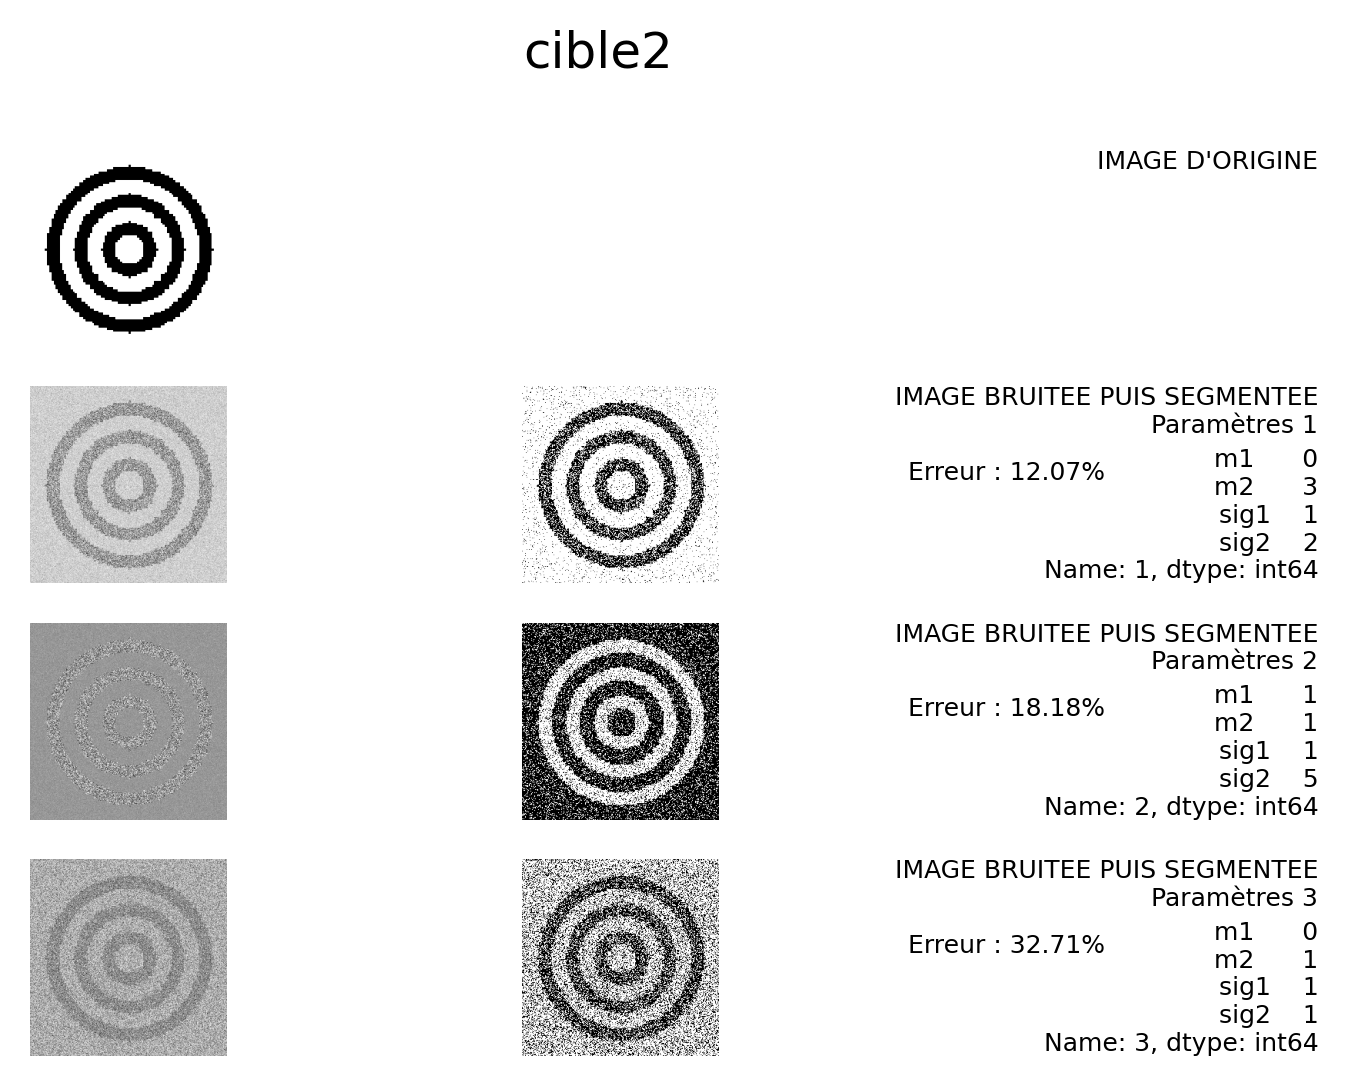

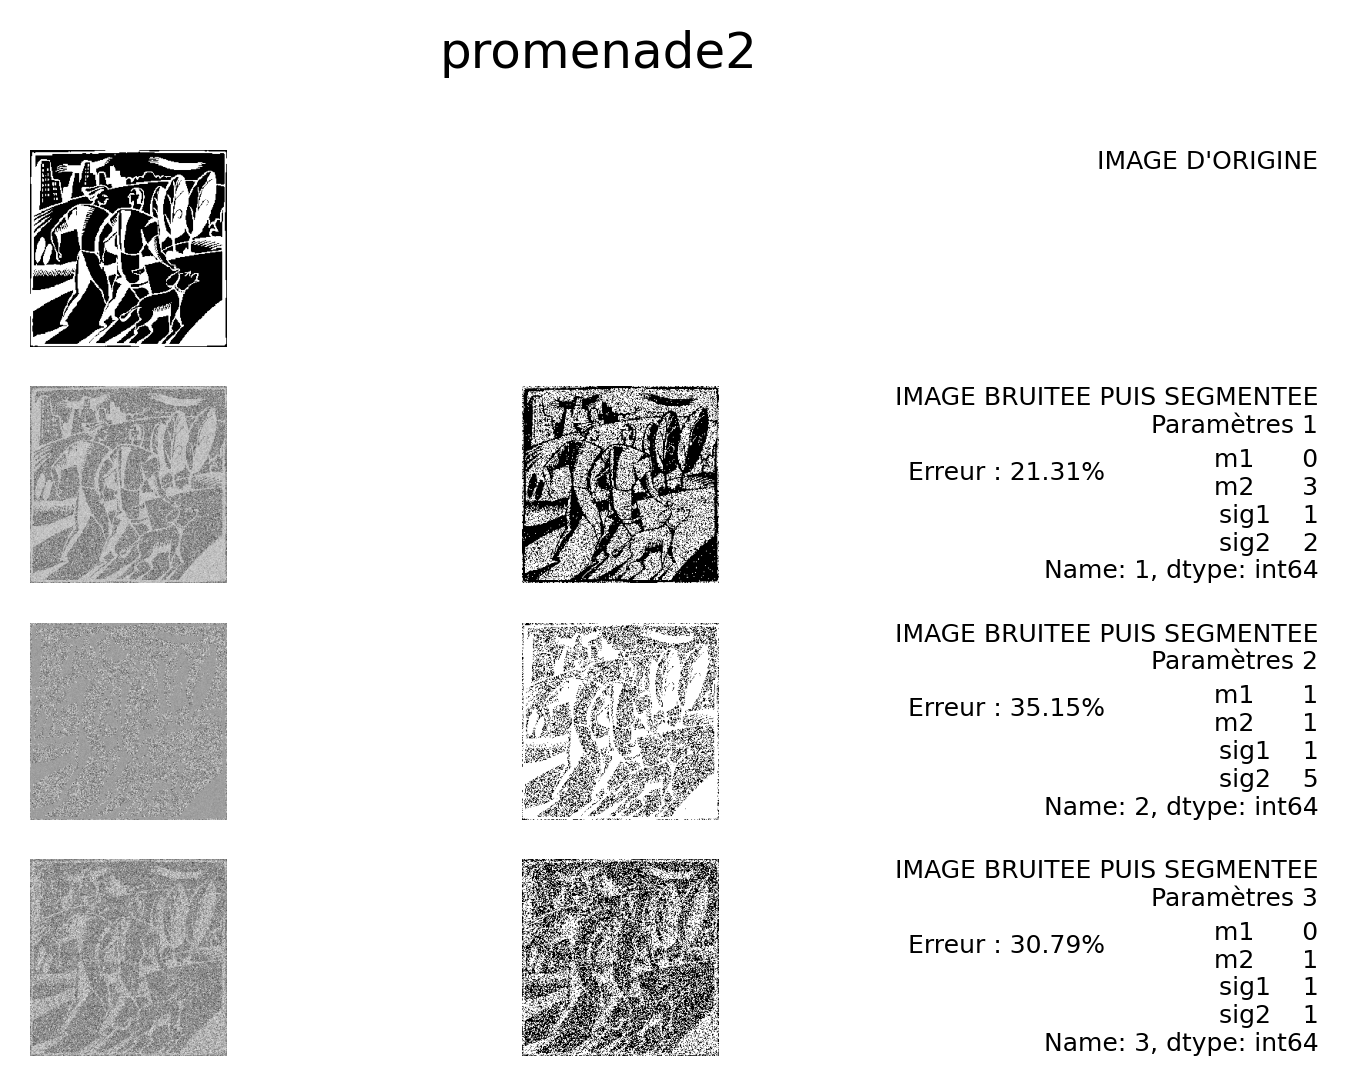

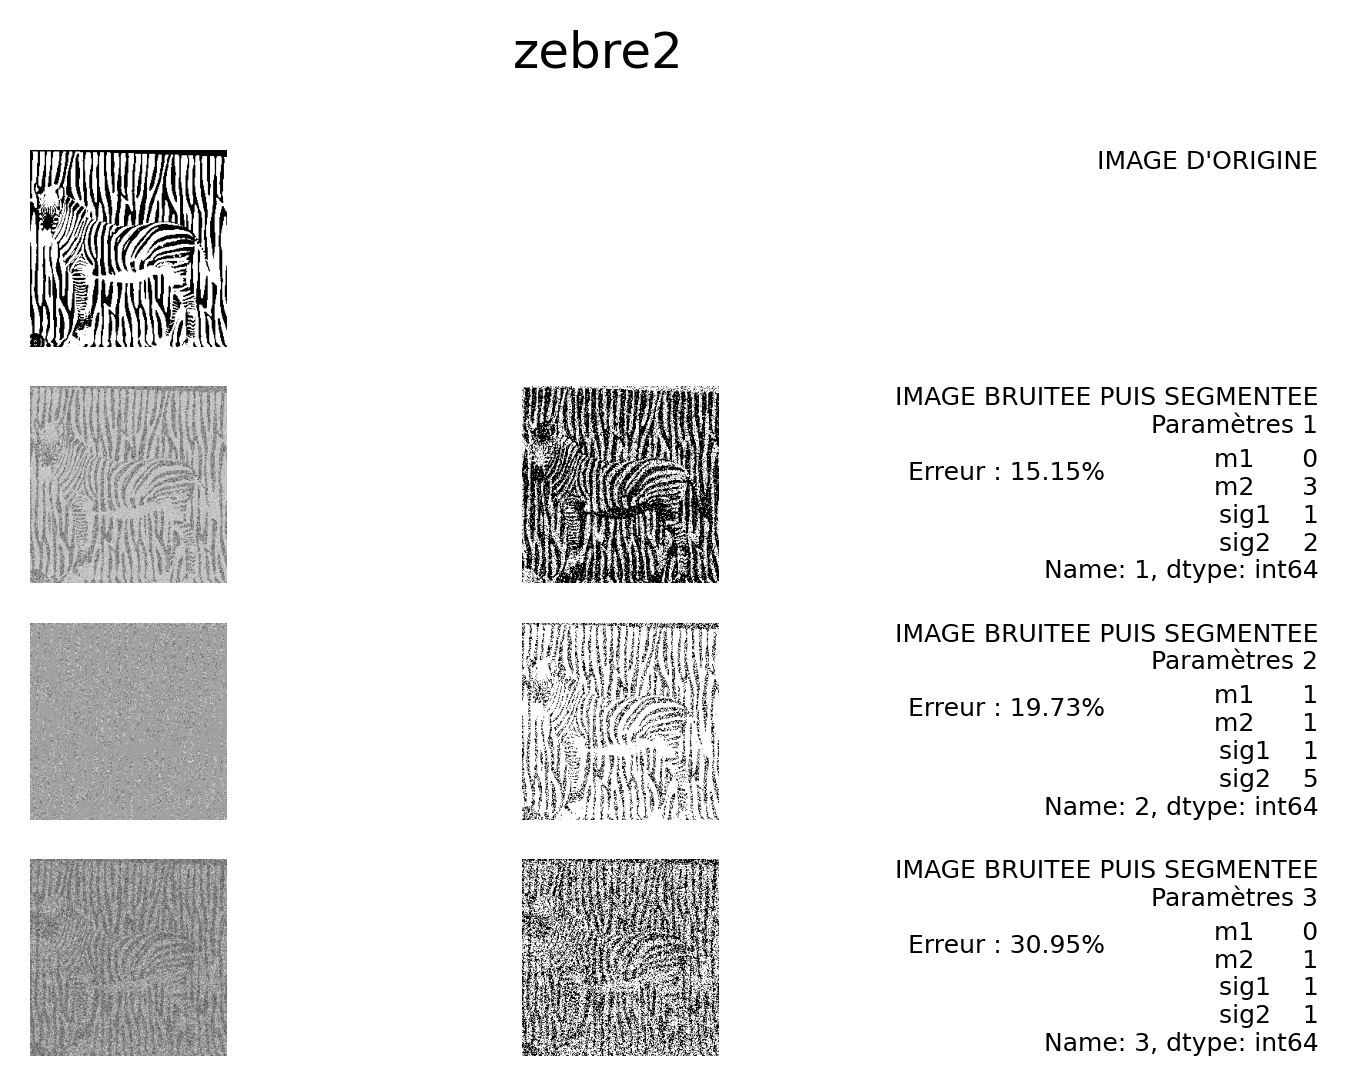

In [8]:
df_Params = pd.DataFrame({'m1':[0,1,0],
                          'm2':[3,1,1],
                          'sig1':[1,1,1],
                          'sig2':[2,5,1]},
                         index = np.arange(3)+1)

tab = []
ImgS = []
List3Img = ["cible2", "promenade2","zebre2"]

#Nboucles = 200
ifig=1
TABError = np.zeros([len(List3Img),len(df_Params)])
for iImg in List3Img:
    tab.append([])
    X,Cl1, Cl2 = OPENPICTURE(FileName = iImg)
    globals()['f'+str(ifig)]=plt.figure(dpi=300)
    pltfigure(globals()['f'+str(ifig)], X, iImg, 0, "IMAGE D'ORIGINE")
    
    isubplot = 1
    for iParams in df_Params.T:   
        Terreur, Xline,Yline, YL2Im, S,Sl2Im =Segmentation_image_indep(X,Cl1, Cl2,
                                                                 df_Params.T[iParams]['m1'],
                                                                 df_Params.T[iParams]['sig1'],
                                                                 df_Params.T[iParams]['m2'],
                                                                 df_Params.T[iParams]['sig2'])
        if Terreur > 0.5:
            Terreur = 1-Terreur
        pltfigure(globals()['f'+str(ifig)], [YL2Im, Sl2Im], iImg, isubplot, "IMAGE BRUITEE PUIS SEGMENTEE\nParamètres " + str(isubplot), Params = df_Params.T[iParams], Terreur = Terreur*100)
        TABError[ifig-1][iParams-1] = Terreur*100
        isubplot += 1   
    ifig+=1

<h3>3.3. Représentation graphique des 3 configurations de $\mu$ et de $\sigma$</h3>

In [9]:
df_Params

,m1,m2,sig1,sig2
1,0,3,1,2
2,1,1,1,5
3,0,1,1,1


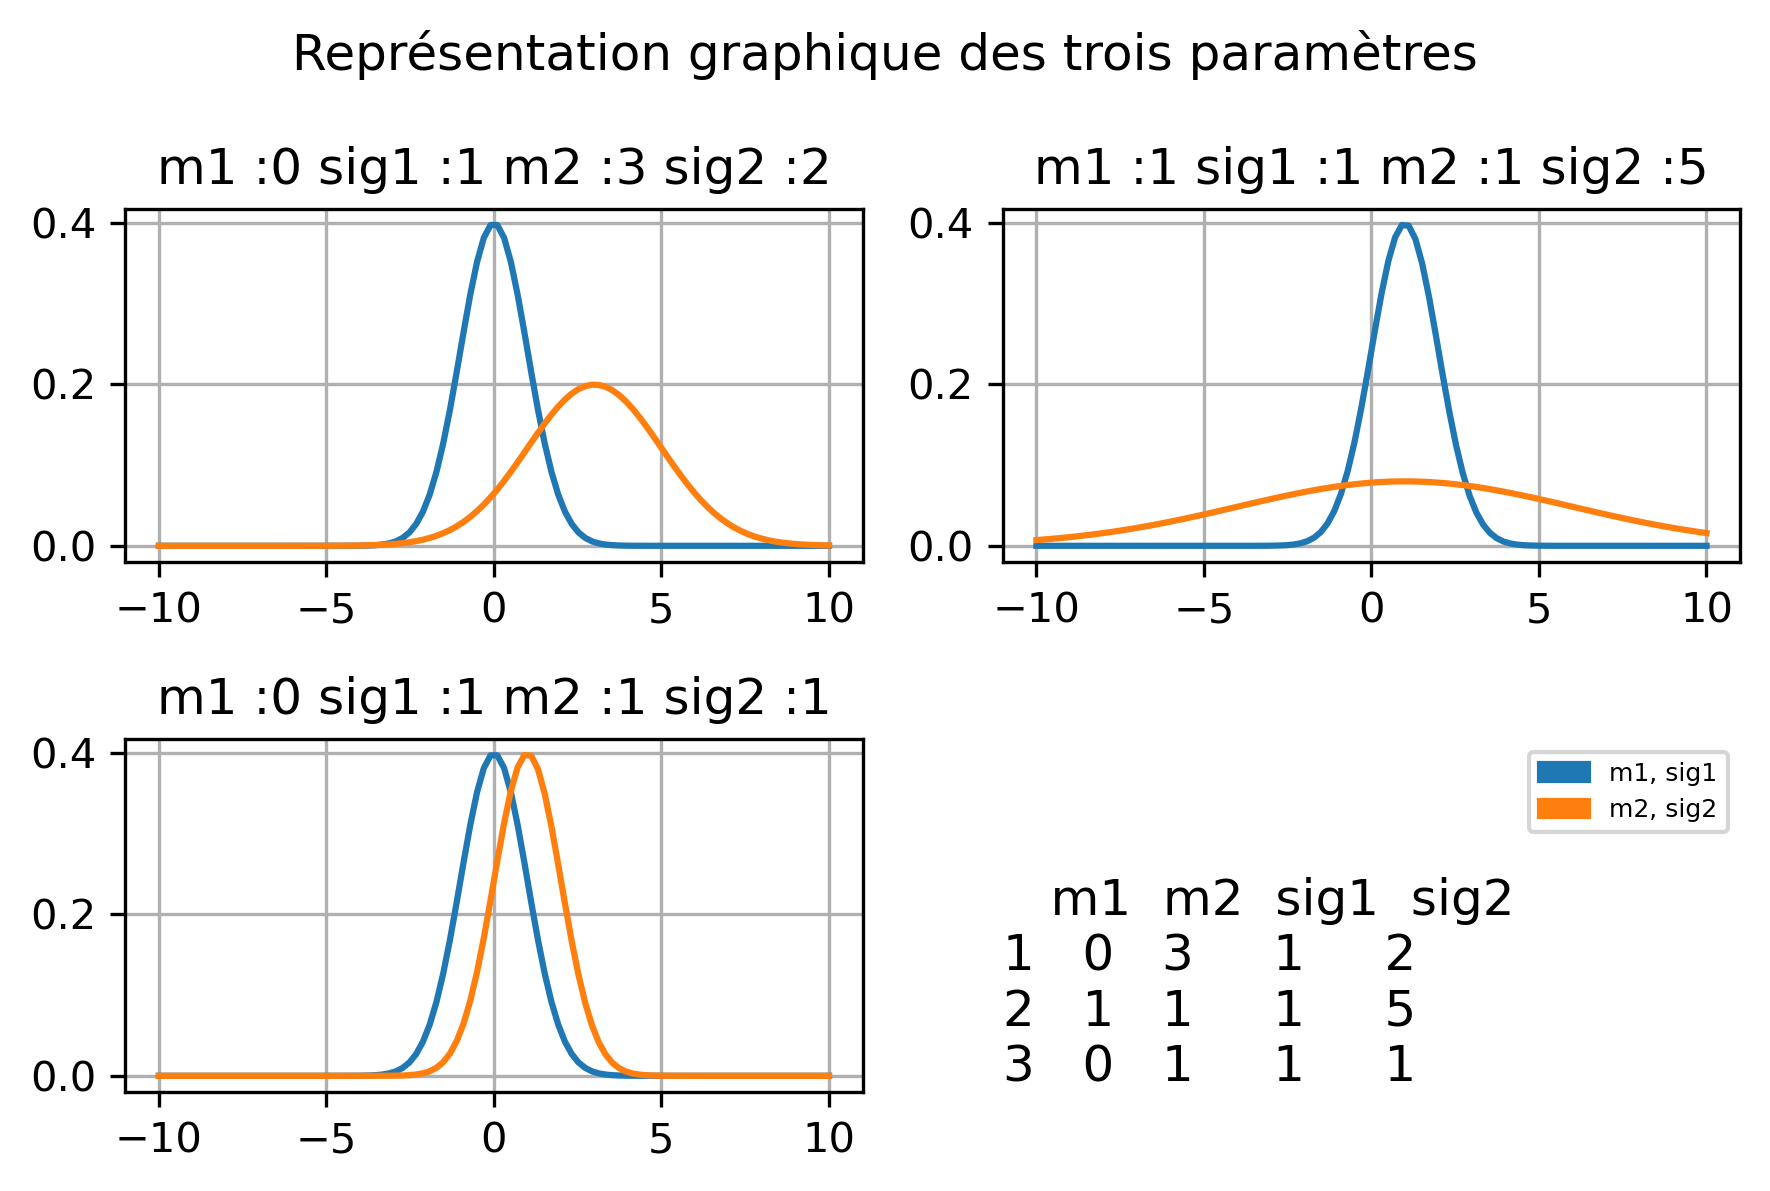

In [12]:
Xrange = np.linspace(-10,10, 100)

plt.figure(dpi=300)
plt.suptitle('Représentation graphique des trois paramètres')
for iParam in range (len(df_Params)):
    plt.subplot(2,2,iParam+1)
    plt.title('m1 :'+ str(df_Params['m1'][iParam+1])+
              ' sig1 :'+ str(df_Params['sig1'][iParam+1])+
              ' m2 :'+ str(df_Params['m2'][iParam+1])+
              ' sig2 :'+ str(df_Params['sig2'][iParam+1]))
    Gauss1 = plt.plot(Xrange, norm.pdf(Xrange, df_Params.iloc[iParam]['m1'], df_Params.iloc[iParam]['sig1']), label = 'm1, sig1')
    Gauss2 = plt.plot(Xrange, norm.pdf(Xrange, df_Params.iloc[iParam]['m2'], df_Params.iloc[iParam]['sig2']), label = 'm2, sig2')
    plt.grid(True)

botrig = plt.subplot(2,2,4)
botrig.clear()
botrig.set_axis_off()
Colr1 = mpatches.Patch(color='C0', label='m1, sig1')
Colr2 = mpatches.Patch(color='C1', label='m2, sig2')
botrig.legend(handles=[Colr1, Colr2], fontsize=6)
plt.text(0, 0,
         str(df_Params),
         horizontalalignment='left',
         verticalalignment='bottom',
         fontsize=12);


plt.tight_layout()
plt.show()

<h3>3.3. Script de comparaison et conclusion</h3>

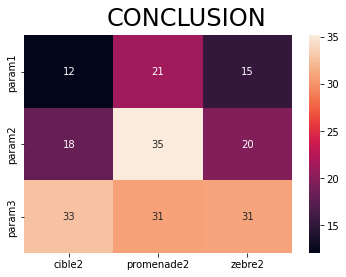

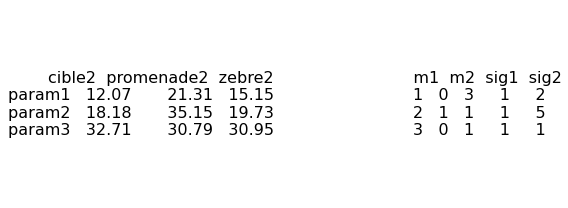

In [76]:
fig = plt.figure()
df_TabError = pd.DataFrame(TABError.T,
                           index = ['param1','param2','param3'],
                           columns=List3Img)
fig.suptitle('CONCLUSION',fontsize=24)
sns.heatmap(df_TabError, annot=True, vmin=np.min(df_TabError.values), vmax=np.max(df_TabError.values));


plt.figure(figsize=(8, 3))
botrig=plt.subplot(1,2,1)
botrig.clear()
botrig.set_axis_off()
plt.text(0, 0.5,
         str(np.round(df_TabError,2)),
         horizontalalignment='center',
         verticalalignment='center',
         fontsize=16);

botrig=plt.subplot(1,2,2)
botrig.clear()
botrig.set_axis_off()
plt.text(1, 0.5,
         str(df_Params),
         horizontalalignment='center',
         verticalalignment='center',
         fontsize=16);

plt.tight_layout()

Quel que soit l'image, le dernier "param3" ($\mu_1=0, \mu_2=1, \sigma_1=1, \sigma_2=1$) paramètre génère le plus d'erreur (31% d'erreur en moyenne pour 200 itérations).
Les paramètres 1 et 2 ($\mu_1={0,1}, \mu_2={3,1}, \sigma_1={1,1}, \sigma_2={2,5}$) ont un résultat assez proche. Le premier est davantage précis pour les images "promenade" et "zebre" (environ 22 et 15% d'erreur en moyenne).
Après plusieurs simulations du script, le taux d'erreur semble identique pour chaque configuration et chaque image.
Mon analyse de ce fait porte plusieurs possibles :
- l'indépendance du modèle
- la complexité de l'image (taux de noir et blanc équilibré ou non, répartition des couleurs)
- l'initialisation des paramètres avec Kmean en fonction de la complexité de l'image (mentionné précédemment)

Autre note : Malgré une bonne similitude des images d'origine et de sortie, nous pouvons constater comme un bruit apparant et homogène sur l'image de sortie (points de blanc ou de noirs dans les zones dont la couleur est l'inverse). Une forme de nuance de gris se rajoute sur l'image d'origine. Ce qui justifie le taux d'erreur pour chaque image.